In [1]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import time
import sys
%matplotlib inline
import random
import copy
import logging
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Setup logging.
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylogBack.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)



Using TensorFlow backend.


In [11]:
class TimeSeriesNN3():
    def __init__(self,STEPS_AHEAD ,NUMBER_TESTING , SERIE, WINDOW):
        self.STEPS_AHEAD = STEPS_AHEAD
        self.WINDOW = WINDOW
        self.NUMBER_TESTING = NUMBER_TESTING
        self.SERIE = SERIE
        self.SIZE = SERIE.shape[0]
        self.NUMBER_TRAINING = self.SIZE - self.NUMBER_TESTING
    
    def divide_testing (self):
        return (self.SERIE[:self.NUMBER_TRAINING],self.SERIE[self.NUMBER_TRAINING:])
    
    def divide_validation (self,serie):
        experimentx = np.zeros((len(serie) - self.WINDOW -self.STEPS_AHEAD + 1, self.WINDOW))
        experimenty = np.zeros((len(serie) - self.WINDOW -self.STEPS_AHEAD + 1,1))
        cnt =  0
        cnt2 = 0
        #serie = serie.reset_index(drop = True)
        for i in range (experimentx.shape[0]):
            cnt += cnt2
            for j in range (self.WINDOW):
                experimentx[i][j] = serie[cnt]
                cnt += 1   
            experimenty[i] = serie[cnt + self.STEPS_AHEAD - 1]
            cnt = 0
            cnt2 += 1           
        return (experimentx, experimenty)
    
    def batch (self):
        training,testing = self.divide_testing()
        tex,tey = self.divide_validation(testing)
        tx,ty = self.divide_validation(training)        
        return (tx,ty) , (tex,tey)
training_data = pd.read_excel("NN3_FINAL_DATASET_WITH_TEST_DATA.xlsx",sheet_name="Hoja 1")
training_data
Serie_1 = training_data.iloc[:, 11:12].values
Serie_1
scaler = MinMaxScaler(feature_range = (0, 1))
Serie_1 = scaler.fit_transform(Serie_1)  
Serie_1

C:\Users\hug0er\Anaconda3\envs\Tesis\lib\site-packages\ipykernel_launcher.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


array([[ 33.],
       [ 12.],
       [ 10.],
       [ 10.],
       [ 18.],
       [ 20.],
       [ 35.],
       [ 24.],
       [ 40.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [ 33.],
       [ 29.],
       [ 22.],
       [ 33.],
       [ 30.],
       [  2.],
       [ 14.],
       [ 26.],
       [ 13.],
       [  9.],
       [ 37.],
       [ 24.],
       [  8.],
       [ 28.],
       [ 64.],
       [ 29.],
       [ 37.],
       [ 69.],
       [ 32.],
       [ 74.],
       [ 22.],
       [ 51.],
       [ 29.],
       [ 66.],
       [ 50.],
       [ 42.],
       [ 22.],
       [ 55.],
       [ 30.],
       [ 27.],
       [ 26.],
       [ 26.],
       [ 28.],
       [ 74.],
       [ 72.],
       [ 76.],
       [ 30.],
       [ 34.],
       [ 37.],
       [ 83.],
       [ 39.],
       [ 53.],
       [  6.],
       [ 31.],
       [ 85.],
       [ 26.],
       [108.],
       [ 36.],
       [ 54.],
       [ 11.],
       [ 39.],
       [ 30.],
       [ 35.],
       [ 3

In [3]:
class Optimizer():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.4,
                 random_select=0.1, mutate_chance=0.2):
        """Create an optimizer.

        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated

        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.

        Args:
            count (int): Number of networks to generate, aka the
                size of the population

        Returns:
            (list): Population of network objects

        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network(self.nn_param_choices)
            network.create_random()

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.accuracy

    def grade(self, pop):
        """Find average fitness for a population.

        Args:
            pop (list): The population of networks

        Returns:
            (float): The average accuracy of the population

        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.

        Args:
            mother (dict): Network parameters
            father (dict): Network parameters

        Returns:
            (list): Two network objects

        """
        children = []
        for _ in range(2):

            child = {}

            # Loop through the parameters and pick params for the kid.
            for param in self.nn_param_choices:
                child[param] = random.choice(
                    [mother.network[param], father.network[param]]
                )

            # Now create a network object.
            network = Network(self.nn_param_choices)
            network.create_set(child)

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.

        Args:
            network (dict): The network parameters to mutate

        Returns:
            (Network): A randomly mutated network object

        """
        # Choose a random key.
        mutation = random.choice(list(self.nn_param_choices.keys()))

        # Mutate one of the params.
        network.network[mutation] = random.choice(self.nn_param_choices[mutation])

        return network

    def evolve(self, pop):
        """Evolve a population of networks.

        Args:
            pop (list): A list of network parameters

        Returns:
            (list): The evolved population of networks

        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen.
        retain_length = int(len(graded)*self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway.
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            male = random.randint(0, parents_length-1)
            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents

In [4]:
class Network():
    """Represent a network and let us operate on it.

    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.

        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        """Create a random network."""
        for key in self.nn_param_choices:
            self.network[key] = random.choice(self.nn_param_choices[key])

    def create_set(self, network):
        """Set network properties.

        Args:
            network (dict): The network parameters

        """
        self.network = network

    def train(self):
        """Train the network and record the accuracy.

        Args:
            dataset (str): Name of dataset to use.

        """
        if self.accuracy == 0.:
            self.accuracy = 1/train_and_score(self.network)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))

In [5]:


# Helper: Early stopping.
early_stopper = EarlyStopping(patience=5)


def compile_model(network, nb_classes):
    """Compile a sequential model.

    Args:
        network (dict): the parameters of the network

    Returns:
        a compiled network.

    """
    # Get our network parameters.
    nb_layers = network['nb_layers']
    nb_neurons = network['nb_neurons']
    i_neurons = network['i_neurons']
    activation = network['activation']
    optimizer = network['optimizer']

    model = Sequential()
    input_shape = (i_neurons, )
    
  

    # Add each layer.
    for i in range(nb_layers):

        # Need input shape for first layer.
        if i == 0:
            model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape))
        else:
            model.add(Dense(nb_neurons, activation=activation))

        model.add(Dropout(0.2))  # hard-coded dropout

    # Output layer.
    model.add(Dense(nb_classes, activation=activation))

    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_squared_error'])

    return model

def train_and_score(network):
    """Train the model, return test loss.

    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating

    """
    batch_size = 1
    i_neurons = network['i_neurons']
    # Set defaults.
    serie1 = TimeSeriesNN3(1,14,Serie_1,i_neurons)

    # Get the data.
    (x_train, y_train), (x_test, y_test) = serie1.batch()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    model = compile_model(network, 1)

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10000,  # using early stopping, so no real limit
              verbose=0,
              validation_data=(x_test, y_test),
              callbacks=[early_stopper])

    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)

    return score[1]  # 1 is accuracy. 0 is loss.

In [6]:

def train_networks(networks):
    """Train each network.

    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """
    pbar = tqdm(total=len(networks))
    for network in networks:
        network.train()
        pbar.update(1)
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.

    Args:
        networks (list): List of networks

    Returns:
        float: The average accuracy of a population of networks.

    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices):
    """Generate a network with the genetic algorithm.

    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating

    """
    optimizer = Optimizer(nn_param_choices)
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        logging.info("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks.
        train_networks(networks)

        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80)

        # Evolve, except on the last iteration.
        if (i != generations - 1):
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])
    print(networks[:5])

def print_networks(networks):
    """Print a list of networks.

    Args:
        networks (list): The population of networks

    """
    logging.info('-'*80)
    for network in networks:
        network.print_network()

def main():
    generations = 5  # Number of times to evole the population.
    population = 20  # Number of networks in each generation.

    nn_param_choices = {
        'nb_neurons': [4,6,8,10,12,16,20],
        'i_neurons': [4,8,12],
        'nb_layers': [1, 2, 3, 4],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
        'optimizer': ['adam', 'sgd'],
    }

    logging.info("***Evolving %d generations with population %d***" %
                 (generations, population))

    generate(generations, population, nn_param_choices)



In [39]:
main()


    

  0%|          | 0/20 [00:00<?, ?it/s]

[0.019112933427095413, 0.019112933427095413]


  5%|▌         | 1/20 [00:09<02:55,  9.23s/it]

[0.05342691019177437, 0.05342691019177437]


 10%|█         | 2/20 [00:25<03:25, 11.40s/it]

[0.061087753623723984, 0.061087753623723984]


 15%|█▌        | 3/20 [00:47<04:04, 14.37s/it]

[0.05263219773769379, 0.05263219773769379]


 20%|██        | 4/20 [01:14<04:53, 18.31s/it]

[0.0776003748178482, 0.0776003748178482]


 25%|██▌       | 5/20 [01:24<03:59, 15.96s/it]

[0.04906023293733597, 0.04906023293733597]


 30%|███       | 6/20 [01:38<03:33, 15.24s/it]

[0.01042313314974308, 0.01042313314974308]


 35%|███▌      | 7/20 [01:45<02:46, 12.84s/it]

[0.05850095674395561, 0.05850095674395561]


 40%|████      | 8/20 [02:02<02:47, 13.98s/it]

[0.05260114744305611, 0.05260114744305611]


 45%|████▌     | 9/20 [02:16<02:34, 14.08s/it]

[0.044363103806972504, 0.044363103806972504]


 50%|█████     | 10/20 [02:35<02:35, 15.53s/it]

[0.05774471536278725, 0.05774471536278725]


 55%|█████▌    | 11/20 [02:50<02:19, 15.47s/it]

[0.050436001271009445, 0.050436001271009445]


 60%|██████    | 12/20 [03:03<01:55, 14.47s/it]

[0.04731632024049759, 0.04731632024049759]


 65%|██████▌   | 13/20 [03:15<01:36, 13.82s/it]

[0.011607229709625244, 0.011607229709625244]


 70%|███████   | 14/20 [03:22<01:10, 11.72s/it]

[0.04643067345023155, 0.04643067345023155]


 75%|███████▌  | 15/20 [03:43<01:13, 14.64s/it]

[0.07762345671653748, 0.07762345671653748]


 80%|████████  | 16/20 [03:51<00:50, 12.70s/it]

[0.011183705180883408, 0.011183705180883408]


 85%|████████▌ | 17/20 [04:00<00:34, 11.57s/it]

[0.012155300937592983, 0.012155300937592983]


 90%|█████████ | 18/20 [04:13<00:23, 11.85s/it]

[0.0006435312679968774, 0.0006435312679968774]


 95%|█████████▌| 19/20 [04:23<00:11, 11.49s/it]

[0.06491941958665848, 0.06491941958665848]


  0%|          | 0/20 [00:00<?, ?it/s]

[0.07665953040122986, 0.07665953040122986]


 50%|█████     | 10/20 [00:14<00:14,  1.47s/it]

[0.0004177698865532875, 0.0004177698865532875]


 55%|█████▌    | 11/20 [00:24<00:35,  3.95s/it]

[0.044680334627628326, 0.044680334627628326]


 60%|██████    | 12/20 [00:52<01:29, 11.20s/it]

[0.047548819333314896, 0.047548819333314896]


 65%|██████▌   | 13/20 [01:17<01:48, 15.45s/it]

[0.05738452449440956, 0.05738452449440956]


 70%|███████   | 14/20 [01:42<01:48, 18.10s/it]

[0.05266120657324791, 0.05266120657324791]


 75%|███████▌  | 15/20 [01:58<01:27, 17.52s/it]

[0.012141548097133636, 0.012141548097133636]


 80%|████████  | 16/20 [02:08<01:00, 15.20s/it]

[0.0017447032732889056, 0.0017447032732889056]


 85%|████████▌ | 17/20 [02:23<00:45, 15.31s/it]

[0.028853345662355423, 0.028853345662355423]


 90%|█████████ | 18/20 [02:34<00:28, 14.08s/it]

[0.05419987440109253, 0.05419987440109253]


 95%|█████████▌| 19/20 [02:52<00:15, 15.21s/it]

[0.05357755720615387, 0.05357755720615387]


  0%|          | 0/20 [00:00<?, ?it/s]

[0.004280616994947195, 0.004280616994947195]


 55%|█████▌    | 11/20 [00:13<00:10,  1.19s/it]

[0.02717185765504837, 0.02717185765504837]


 60%|██████    | 12/20 [00:23<00:31,  3.95s/it]

[0.007313368376344442, 0.007313368376344442]


 65%|██████▌   | 13/20 [00:41<00:58,  8.30s/it]

[0.0501973032951355, 0.0501973032951355]


 70%|███████   | 14/20 [01:05<01:17, 12.95s/it]

[0.024129927158355713, 0.024129927158355713]


 75%|███████▌  | 15/20 [01:19<01:06, 13.23s/it]

[0.01393234170973301, 0.01393234170973301]


 80%|████████  | 16/20 [01:33<00:53, 13.29s/it]

[0.07772527635097504, 0.07772527635097504]


 85%|████████▌ | 17/20 [01:43<00:37, 12.53s/it]

[0.048445284366607666, 0.048445284366607666]


 90%|█████████ | 18/20 [02:16<00:37, 18.70s/it]

[0.04951230436563492, 0.04951230436563492]


 95%|█████████▌| 19/20 [02:44<00:21, 21.31s/it]

[0.06278835237026215, 0.06278835237026215]


  0%|          | 0/20 [00:00<?, ?it/s]

[0.07550659775733948, 0.07550659775733948]


 55%|█████▌    | 11/20 [00:19<00:15,  1.74s/it]

[0.04761826619505882, 0.04761826619505882]


 60%|██████    | 12/20 [00:55<01:35, 11.99s/it]

[0.011192601174116135, 0.011192601174116135]


 65%|██████▌   | 13/20 [01:02<01:14, 10.62s/it]

[0.0246235653758049, 0.0246235653758049]


 70%|███████   | 14/20 [01:12<01:02, 10.47s/it]

[0.01086095254868269, 0.01086095254868269]


 75%|███████▌  | 15/20 [01:28<01:00, 12.13s/it]

[0.009866669774055481, 0.009866669774055481]


 80%|████████  | 16/20 [01:45<00:54, 13.67s/it]

[0.01013569999486208, 0.01013569999486208]


 85%|████████▌ | 17/20 [01:58<00:39, 13.31s/it]

[0.013831079937517643, 0.013831079937517643]


 90%|█████████ | 18/20 [02:19<00:31, 15.65s/it]

[0.0034243972040712833, 0.0034243972040712833]


 95%|█████████▌| 19/20 [02:53<00:21, 21.13s/it]

[0.02974383905529976, 0.02974383905529976]


  0%|          | 0/20 [00:00<?, ?it/s]

[0.006563105620443821, 0.006563105620443821]


 45%|████▌     | 9/20 [00:08<00:10,  1.09it/s]

[0.011269425973296165, 0.011269425973296165]


 50%|█████     | 10/20 [00:17<00:32,  3.26s/it]

[0.0023350007832050323, 0.0023350007832050323]


 55%|█████▌    | 11/20 [00:29<00:53,  5.98s/it]

[0.010550727136433125, 0.010550727136433125]


 60%|██████    | 12/20 [00:40<01:00,  7.61s/it]

[0.007573720533400774, 0.007573720533400774]


 65%|██████▌   | 13/20 [00:57<01:11, 10.25s/it]

[0.00947473756968975, 0.00947473756968975]


 70%|███████   | 14/20 [01:07<01:00, 10.16s/it]

[0.010507846251130104, 0.010507846251130104]


 75%|███████▌  | 15/20 [01:17<00:50, 10.16s/it]

[0.0033147220965474844, 0.0033147220965474844]


 80%|████████  | 16/20 [01:33<00:48, 12.08s/it]

[0.007763369474560022, 0.007763369474560022]


 85%|████████▌ | 17/20 [02:01<00:50, 16.72s/it]

[0.011500143446028233, 0.011500143446028233]


 90%|█████████ | 18/20 [02:18<00:33, 16.81s/it]

[0.009173628874123096, 0.009173628874123096]


 95%|█████████▌| 19/20 [02:32<00:16, 16.15s/it]

[0.010876314714550972, 0.010876314714550972]


100%|██████████| 20/20 [02:45<00:00, 14.97s/it]


[<__main__.Network object at 0x0000022AFF229FD0>, <__main__.Network object at 0x0000022B0BA6BC50>, <__main__.Network object at 0x0000022B219A7240>, <__main__.Network object at 0x0000022B33898DA0>, <__main__.Network object at 0x0000022B3B98FE48>]


In [9]:
early_stopper = EarlyStopping(patience=5)
logging.info('entrada')
batch_size = 1
i_neurons = 10
nb_layers = 1
nb_neurons = 8
activation = 'relu'
optimizer = 'adam'
nb_classes = 1



model = Sequential()
input_shape = (i_neurons, )



# Add each layer.
for i in range(nb_layers):

    # Need input shape for first layer.
    if i == 0:
        model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape))
    else:
        model.add(Dense(nb_neurons, activation=activation))

    model.add(Dropout(0.2))  # hard-coded dropout

# Output layer.
model.add(Dense(nb_classes, activation=activation))

model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_squared_error'])


# Set defaults.
serie1 = TimeSeriesNN3(1,14,Serie_1,i_neurons)

# Get the data.
(x_train, y_train), (x_test, y_test) = serie1.batch()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10000,  # using early stopping, so no real limit
          verbose=0,
          validation_data=(x_test, y_test),
          callbacks=[early_stopper])

score = model.evaluate(x_test, y_test, verbose=0)
print(score)
logging.info('salida')

[0.004857304506003857, 0.004857304506003857]


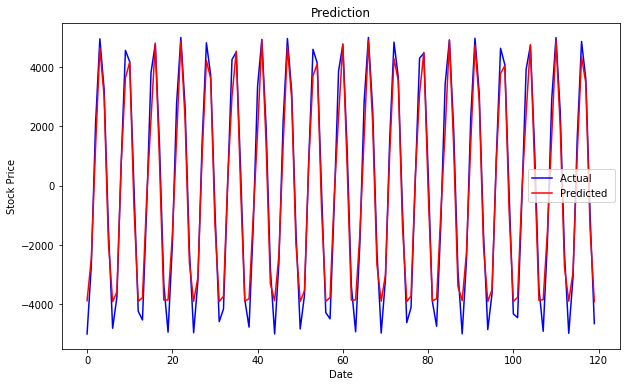

In [10]:
predictions = model.predict(x_train)  
predictions = scaler.inverse_transform(predictions) 
labelsf = scaler.inverse_transform( y_train) 
plt.figure(figsize=(10,6))  
plt.plot(labelsf, color='blue', label='Actual ')  
plt.plot(predictions , color='red', label='Predicted ')  
plt.title('Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()  